In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from keras.optimizers import SGD
import os

%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from pylab import *

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define train/test/validation directories
train_dir = 'Case2_XRay/train'
test_dir = 'Case2_XRay/test'
validation_dir = 'Case2_XRay/validation'


TS = (150, 150) # Image size
BS = 32 # Batch size

tg = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

devg = ImageDataGenerator(rescale=1./255)
testg = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode='binary')

dev_generator = devg.flow_from_directory(
    validation_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode='binary')

test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode='binary')

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


In [4]:
i = 0
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    i = i + 1
    if i > 5:
        break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


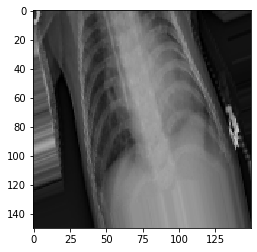

In [5]:
imshow(data_batch[0])
show()

In [6]:
 # Model 3
# https://keras.io/applications/
# We wanted to try a model with pretrained values. 

from keras.applications import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


base_model = VGG19(weights='imagenet', include_top= False, input_shape=(150,150,3))

# a global spatial average pooling layer 
x = base_model.output
x = GlobalAveragePooling2D()(x)

# adding a fully-connected layer
x = Dense(512, activation='relu')(x)


predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [9]:
import tensorflow as tf
# http://marubon-ds.blogspot.com/2017/09/vgg-fine-tuning-model.html

# Define metrics
my_metrics = [tf.keras.metrics.SensitivityAtSpecificity(0.6)]





# freeze pre-trained model area's layer
for layer in base_model.layers:
    layer.trainable = False

# update the weight that are added
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
model.fit(train_generator, steps_per_epoch = 20,
    verbose = 1,
    epochs = 3,
    validation_data = dev_generator,
    validation_steps = 40)

layer_num = len(model.layers)
for layer in model.layers[:21]:
    layer.trainable = False

for layer in model.layers[21:]:
    layer.trainable = True
# training
#model.compile(
  ##  optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9),
   # loss='binary_crossentropy',
   # metrics = my_metrics)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics= my_metrics)
#history = model.fit(train_generator, epochs=2, shuffle=True)

E = 3 # Number of epochs

# Train the model
print('Training ...', end='')
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 20,
    verbose = 1,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = 40,
    callbacks=callbacks_list)


Epoch 1/3
20/20 [==============================] - 449s 22s/step - loss: 0.5481 - val_loss: 1.3307
Epoch 2/3
20/20 [==============================] - 477s 24s/step - loss: 0.3870 - val_loss: 0.4623
Epoch 3/3
19/20 [===========================>..] - ETA: 7s - loss: 0.3834 

KeyboardInterrupt: 

In [ ]:
labels3 = dev_generator.classes # Outputs from training
predicted3 = model.predict_generator(dev_generator).flatten()  # Predicted values

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels3, predicted3, pos_label = 1)

# Plot ROC curve
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

In [ ]:
# Confusion matrix
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels3, predicted3 > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels3, predicted3 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

In [ ]:
# Classification report
cr = classification_report(labels3, predicted3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

In [ ]:
# Threhold analysis
plot(thresholds, 1 -fpr, label = 'Specificity')
plot(thresholds, 1 -tpr, label = 'Sensitivity')
axvline(0.6, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

In [ ]:
# Compile model again
#model.compile(
    #optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    #loss='binary_crossentropy',
    #metrics = my_metrics)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics= my_metrics)

In [ ]:
labels3 = test_generator.classes # Outputs from training
predicted3 = model.predict_generator(test_generator).flatten()  # Predicted values using validation data

In [ ]:
# Confusion matrix from validation
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels3, predicted3 > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels3, predicted3 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

In [ ]:
# Classification report from validation
cr = classification_report(labels3, predicted3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)